## LeNet implementation in PyTorch 🏋🏻

1. Load MNIST dataset
2. Create ConvNet (LeNet)
3. Train model
4. Evaluate model

---

### 1. Load MNIST dataset

In [42]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2

In [43]:
transforms = v2.Compose(
    [
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.MNIST(
    "./data", train=True, transform=transforms, download=True
)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)

In [44]:
data_iter = iter(training_loader)
images, labels = next(data_iter)
print(f"{images.shape=}; {labels=}")

images.shape=torch.Size([4, 1, 28, 28]); labels=tensor([8, 9, 9, 2])


So, we have a batch of 4 images and their labels are `5, 8, 3, 8`.

### Let's visualize them.

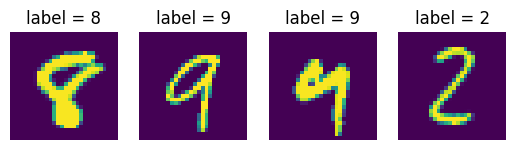

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4)  # 1 row & 4 column

for i in range(4):
    ax[i].imshow(images[i].permute(1, 2, 0))
    ax[i].set_title(f"label = {labels[i]}")
    ax[i].axis('off')

plt.show()

---

### 2. Now, let's recreate `LeNet-5` ConvNet architecture.

![LeNet](../00_assets/LeNet.png)

In [46]:
class LeNetModel(nn.Module):
    def __init__(self):
        super(LeNetModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.relu(y)
        y = self.fc3(y)
        return y

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LeNetModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # learning rate needs to be really low.
loss_fn = torch.nn.CrossEntropyLoss()

---

### 3. Train the model

In [48]:
all_epoch = 10
prev_acc = 0
for current_epoch in range(all_epoch):
    model.train()
    print(f"Epoch: {current_epoch+1}")
    for idx, (train_x, train_label) in enumerate(training_loader):
        train_x = train_x.to(device)
        train_label = train_label.to(device)

        optimizer.zero_grad()
        predict_y = model(train_x)
        loss = loss_fn(predict_y, train_label)
        loss.backward()
        optimizer.step()

    # evaluate model for this epoch
    model.eval()
    total_training_loss = 0
    with torch.no_grad():
        for idx, (test_x, test_label) in enumerate(training_loader):
            test_x = test_x.to(device)
            test_label = test_label.to(device)
            predict_y = model(test_x)
            loss = loss_fn(predict_y, test_label)
            total_training_loss += loss

    avg_training_loss = total_training_loss / (len(training_loader) * 4)  # batch size=4
    print(f"    average training loss: => {avg_training_loss}")

Epoch: 1
    average training loss: => 0.0360366627573967
Epoch: 2
    average training loss: => 0.02064746432006359
Epoch: 3
    average training loss: => 0.017217006534337997
Epoch: 4
    average training loss: => 0.014333718456327915
Epoch: 5
    average training loss: => 0.00955561175942421
Epoch: 6
    average training loss: => 0.00798304844647646
Epoch: 7
    average training loss: => 0.007318887859582901
Epoch: 8
    average training loss: => 0.005758797284215689
Epoch: 9
    average training loss: => 0.006789619568735361
Epoch: 10
    average training loss: => 0.0050499760545790195


---

### 4. Calculate accuracy

In [49]:
total_correct_pred = 0
total_incorrect_pred = 0

model.eval()
with torch.no_grad():
    for idx, (test_x, test_label) in enumerate(training_loader):
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model(test_x)
        predict_output = torch.argmax(predict_y, dim=1)

        total_correct_pred += (predict_output == test_label).sum()
        total_incorrect_pred += (predict_output != test_label).sum()

total_correct_pred = total_correct_pred.item()
total_incorrect_pred = total_incorrect_pred.item()
accuracy = total_correct_pred/ (total_correct_pred+total_incorrect_pred)

print(f"{total_correct_pred=}; {total_incorrect_pred=}")
print(f"accuracy: {accuracy}")

total_correct_pred=59622; total_incorrect_pred=378
accuracy: 0.9937


---

### 4. Visualize predictions with correct labels

In [50]:
data_iter = iter(training_loader)
images, labels = next(data_iter)
print(f"{images.shape=}; {labels=}")

# get the prediction
model.eval()
with torch.no_grad():
    prediction = model(images.to(device))
    predict_output = torch.argmax(prediction, dim=1)
print(f"{labels=}; {predict_output=}")

images.shape=torch.Size([4, 1, 28, 28]); labels=tensor([9, 9, 2, 7])
labels=tensor([9, 9, 2, 7]); predict_output=tensor([9, 9, 2, 7])


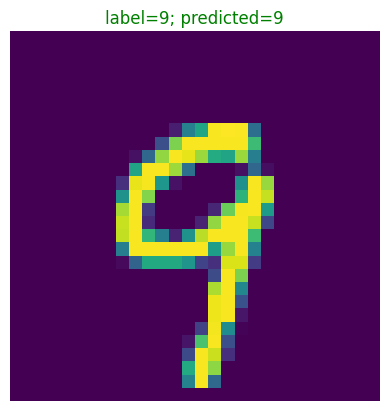

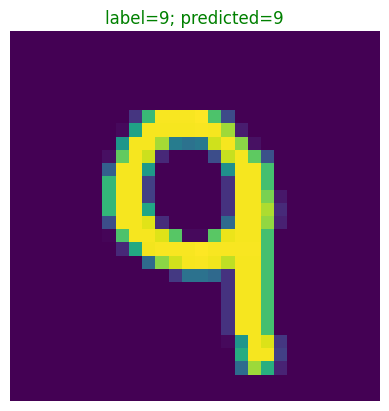

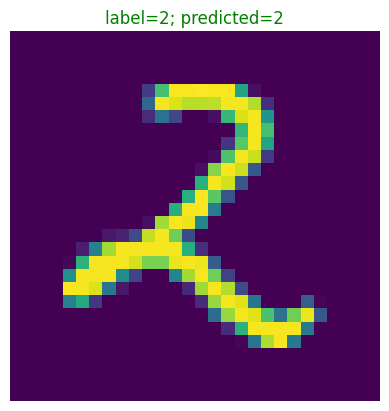

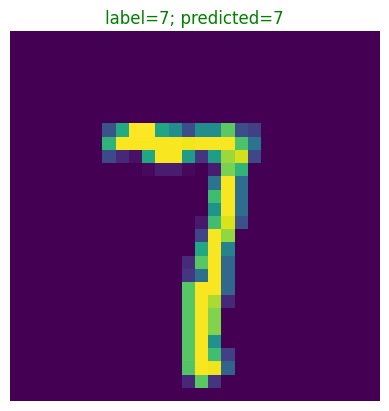

In [51]:
def visualize_img(img_to_visualize, img_label, img_prediction):
    color = "red"
    if img_label == img_prediction:
        color = "green"
    plt.imshow(img_to_visualize.permute(1, 2, 0))
    plt.title(f"label={img_label}; predicted={img_prediction}", color=color)
    plt.axis("off")
    plt.show()


for i in range(4):
    visualize_img(images[i], labels[i], predict_output[i])